#Алгоритм "Ближайшая Оптимизация Политики"

В предыдущем занятии, мы рассмотрели алгоритм 'преймущественный актёр-критик' (A2C). Этот алгоритм характеруезается тем, что есть актёр (агент) который взамодействует с окружающей средой, и есть отдельный от него критик который помогает агенту обучаться.

Выше упомянутый алгоритм также отличается тем, что он может обучаться на пакете данных (обычно, полный эпизод) всего один раз. Это означает, что агент должен сгенерировать целый эпизод данных, чтобы затем провести всего один шаг градиентного спуска. Это может быть весьма проблиматично, учитывая что один эпизод запросто может содержать тысячи или даже десятки тысяч сэмплов.

В данном занятии, мы рассмотрим алгоритм, который известен под названием "*Ближайшая Оптимизация Политики*" - *БОП (англ. Proximal Policy Optimization - PPO)*, который предназначен именно для решения этой проблемы.

Алгоритм БОП является одним из алгоритмов школы актёр-критик, и считается более совершенной, чем алгоритм A2C. 

На самом деле, разница между этими двумя алгоритмами совсем не большая. Всё, что нужно сделать в Керасе, чтобы превратить алгоритм A2C в алгоритм БОП, это поменять функцию ошибки актёра.

In [ ]:
#Функция ошибки актёра (алгоритм A2C)
#Это - функция ошибки категориальной кроссэнтропии. Её можно задавать в Керасе через строку:
loss = 'categorical_crossentropy'

#Однако, если мы захотим создать эту функцию в ручную, она будет выглядеть следующим образом
def A2C_actor_loss(y_true, y_pred):
  loss = -1 * (y_true * K.log(y_pred) + (1 - y_true) * K.log(1 - y_pred)) #Уравнение категориальной кроссэнтропии
  return K.mean(loss, axis = 0) #Берём среднее значение ошибки с всех примеров с батча (это стандартное правило)

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------

#Функция ошибки актёра (алгоритм БОП)
def PPO_actor_loss(y_true, y_pred):
  old_probabilities, advantages, onehot_actions = y_true[:, 0], y_true[:, 1], y_true[:, 2:]  #Распаковываем входные данные в три отдельные переменные

  probabilities = K.sum(y_pred * onehot_actions, axis = 1) #Считаем вероятности, с которой агент принимает действия с эпизода
  ratio = probabilities / old_probabilities      #Считаем соотношение между новыми вероятностями и старыми вероятностями

  loss_clip_value = 0.2    #Гиперпараметр, который влияет на размер доверительного региона (см. далее)

  advantage_ratio = ratio * advantages #Умножаем преймущества на соотношения
  clipped_advantage_ratio = K.clip(ratio, min_value = 1 - loss_clip_value, max_value = 1 + loss_clip_value) * advantages #Умножаем срезаные преймущества на соотношения
  
  loss = K.minimum(advantage_ratio, clipped_advantage_ratio) #Функция ошибки является минимумом из двух выше-указанных переменных
  return K.mean(loss, axis = 0) #Берём среднее значение ошибки с всех примеров с батча (это стандартное правило)

В выше-указанном коде, функция ошибки использует четыре переменные. Однако, функции ошибки Кераса могут принимать лишь две функции ошибки на вход, и по этому мы распаковываем переменную `y_true` в три отдельных переменных.

**Входные параметры функции ошибки БОП**

`onehot_actions` - это массив всех действий, который агент предпринял в эпизоде (представленные в виде one-hot массива).

`advantages` - это преймущества (они считаются также как в предыдущем занятии, перед подачей в функцию ошибки).

`old_probabilities` - это новая переменная. Здесь содержутся **вероятности**, которые агент предсказал для выбора каждого действия из массива `onehot_actions`. (Напоминаем, что выбор действия в политических методов происходит рандомно, используя вероятности которые предсказывает актёр).

Изменение функции ошибки - это основное, что нам нужно сделать.

Однако, чтобы воспользоваться преймуществами новой функции ошибки, нам нужно совсем чуть-чуть поменять код обучения модели:

In [ ]:
#Код из алгоритма A2C (сеть обучается на целом эпизоде как один батч)
model.train_on_batch(x_train, y_train)

На:

In [ ]:
#Код из алгоритма БОП (сеть обучается на отдельных мини-батчах из эпизода)
#Именно тут содержиться преймущество БОП!!! Нам больше не нужно генерить целый эпизод чтобы совершить один, маленький шаг обучения!
model.fit(x_train, y_train, batch_size = batch_size)

И это всё! Изменив всего эти две вещи, происходит огромное усовершенствование алгоритма A2C.

Мы объяснили что нужно сделать, чтобы создать и обучить алгоритм БОП. Давайте теперь объясним на теоретическом уровне, именно *зачем* мы всё это делаем.

#Теоретическая суть алгоритма БОП

Сперва мы должны ознакомиться с новым термином: **доверительный регион** *(англ. trust region).*

Давайте представим все параметры нейронной сети (актёра) в качестве единного пространства. Доверительный регион - это условная, небольшая область в данном ландшафте, где мы можем совершать градиентный спуск (и обучаться засчет этого). Если шаг обучения выходит за пределы этого региона, он скорее всего приведет к переобучению и разрушит ранее достигнутый прогресс. 

То есть, чтобы добиться правильного и стабильного обучения, все шаги обучения должны происходить внутри заданного доверительного региона (который в свою очередь обновляется после каждого шага). 

Первое, что приходит в голову, это уменьшение шага обучения - ведь если мы будем делать маленькие шаги, они должны происходить внутри региона доверенности. Это действительно так, но практика показывает что в таком случае нужно на столько снизить шаг обучения, что сеть вовсе перестает обучаться.

Это означает, что нам нужен специальный алгоритм, который ограничивает градиентный спуск в рамках доверительного региона. На самом деле, есть несколько разных алгоритмов, которые именно это и делают - самый первый алгоритм был описан в статье *Trust Region Policy Optimization*, (TRPO) которая вышла в 2015-м году.

Алгоритм TRPO довольно сложный в теории, и требует не мало вычислительных ресурсов для подсчета доверительного региона. Мы не будем рассматривать этот алгоритм в текущем занятии - важно лишь знать, что такой алгоритм существует, и что он был предшественником БОП. 

______________________________

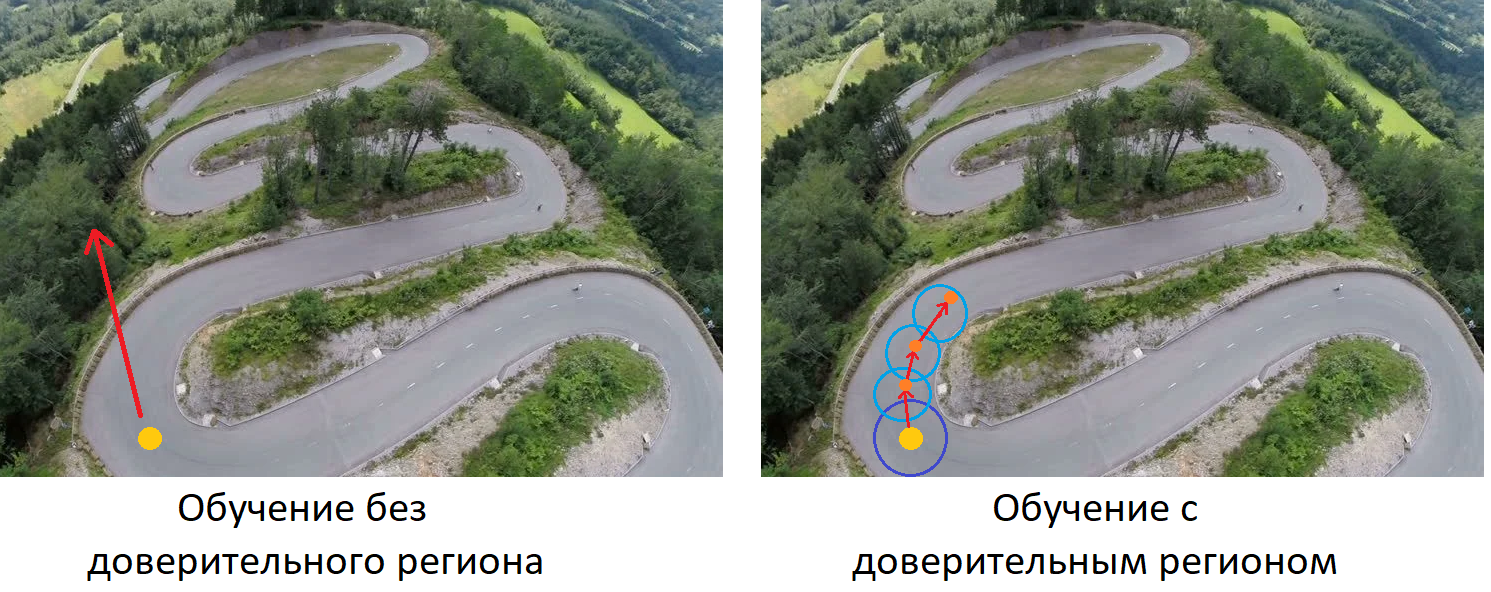

**Изображение №1**

<font color='gray'> *Картинка выше демонстрирует суть того, что происходит при попытке обучить сеть на минибатчах используя алгоритмы REINFORCE/A2C (слева) и алгоритмы TRPO/PPO (справа).* </font>


В 2017-м году вышла статья, которая описывала намного более простой и эффективный алгоритм, чем TRPO. Именно этот алгоритм был назван *ближайщая оптимизация политики*.

Основная суть этого алгоритма заключается в том, что функция ошибки актёра меняется именно таким образом, что фактический задается Доверительный регион. В отличии от алгоритма TRPO (где Доверительный регион задается явным способом и его границы чётко определяются в самом уравнении), в БОП доверительный регион является неявным. 

Иными словами, функция ошибки в БОП создана так, чтобы алгоритм обучался *как будто* у него есть чётко-заданный регоин доверенности. Термин *оптимизация ближайшей политики* от сюда и берётся: политика агента оптимизируется именно в рамках регоина доверенности.

Это, по сути всё, что касается алгоритма БОП. Однако, в данном занятии мы пройдем ещё одну очень большую тему.

#Непрерывные действия

Все сценарии которые мы пока-что рассматривали в занятиях, были построены на основе **дискретных действий**, где есть ряд из нескольких возможных из которых агент должен выбирать правильное действие. Но что если мы представим задачу, где например, агент должен водить машиной? 

В этом случае, агент может повернуть руль вправо на 10 градусов, либо на 11, на 12, на 12.5, на 12.6 и тд. Также, агент сможет нажать на газ либо на тормоз на 50%, или на 51%, на 52%, и тд.

Аналогичные сценарии можно представить при попытке управлять беспилотником, где можно включать передние или задние винты на разную мощность, ставить элероны в разные положения, и тд. Также можно представить и ситуацию, где агент контролирует действия какого-нибудь робота, и цель стоит: обучить робота ходить по поверхности.

Все выше-описанные сценарии содержут пространство действий, которое **непрерывное**. Т.е. здесь больше нету дисктерных действий, и задача уже не является примером классификации, а скорее чуть больше похожа на регрессию. 

Такие задачи не получается решить через алгоритмы вроде Q-обучения, однако некоторые политические алгоритмы способны с ними справляться. 

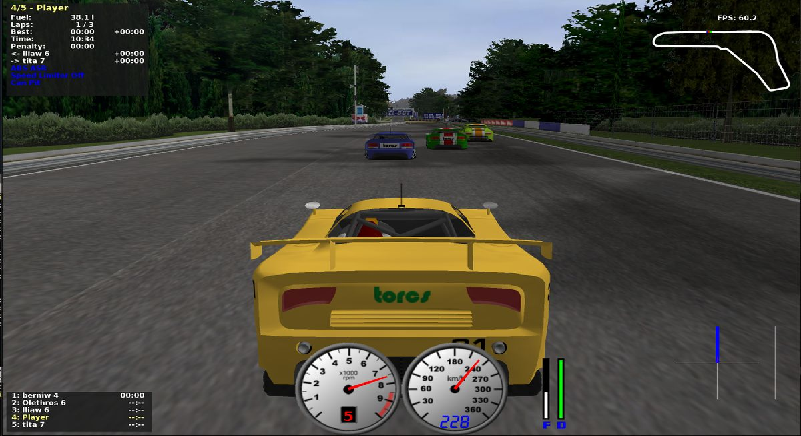

###Вариант - превратить непрерывные действия в дискретные

Самое простое решение для таких задач: преобразовать непрерывное пространство действий в дискретное пространство.

То есть, если действие - это вектор из трёх элементов (позиция руля, газ, и тормоз), мы можем просто сказать агенту, что он может выбрать только несколько конкретных действий:

In [ ]:
#Мы можем превращать непрерывное пространство действий в дискретное следующим образом

action_space = [[1.0, 0.0, 0.0],   #Значения массива действий для резкого поворота на право
                [-1.0, 0.0, 0.0],  #Значения массива действий для резкого поворота на лево
                [0.0, 1.0, 0.0],   #Значения массива действий для 100% газа
                [0.0, 0.0, 1.0],   #Значения массива действий для 100% тормоза
                [0.0, 0.0, 0.0]]   #Значения массива действий чтобы ничего не делать (т.е. просто ждать)

Однако, в таком случае, мы сильно ограничиваем возможности нашего агента - ведь он больше не сможет принимать все остальные действия, которые не указаны в `action_space`.

Если мы добавим больше вариантов действий в `action_space` (например, отдельно добавим возможность использовать 90% газа, 80%, и тд. мы увидем, что наше пространство действий станет неприемлемо большим - оно будет содержать сотни и тысячи действий, и агент не сможет на этом обучаться.

Однако, чем меньше дискретных действий мы выбираем, тем меньше вероятность - что выбранные дискретные действия будут приемлемы для обучения.

То есть, преобразование непрерывных действий в дискретные является далеко не оптимальным, даже если это иногда используется на практике.

**Изображение №2**

<font color='gray'> *TORCS - это пример виртуальной среды, которая предназначена для обучения нейронных сетей. В этой среде, агент должен научиться управлять машиной и побеждать своих соперников в гонке.* 

*TORCS не поддерживается на гугл-колабе, и по этому мы его не будем использовать в лекциях. Однако, его можно установить и использовать в питоне на локальной машине.* </font>

[*Перейти на официальный сайт TORCS можно по этой ссылке.*](http://torcs.sourceforge.net/)



###Предсказывание непрерывных действий через алгоритмы актёр-критик

В случае с дискретными действиями, агент имеет активационную функцию `softmax` и предсказывает вероятность принятия каждого действия. Таким образом, у агента есть небольшая вероятность принять не-политическое действие. Именно благодаря этому факту, агент исследует среду.

В случае с непрерывными действиями, мы уже не используем активационную функцию `softmax`, а обычно используем `sigmoid`, `tanh`, `linear`, и тд. (в зависимости от диапазона возможных действий). Агент предсказывает набор значений, и чтобы агент исследовал срежу, нам нужно добавить *шум* к этим действиям.

_____________________________________

Есть много разных алгоритмов и способов добавлять шум к предсказанным действиям. На этом занятии, мы рассмотрим вариант использования Гауссовкого распределения для добавления шума. То есть, логика принятия нужного действия будет выглядеть следующим образом: 

In [ ]:
#Функция, которая принимает на вход состояние среды и возвращает нужное действие агента
def choose_action(state):
  predicted_actions = actor.predict(state) #Предсказываем действие актёру по состоянию

  standard_deviation = 0.4 #Обозначаем стандартное отклонение, с которым создадим шум
  gaussian_noise = np.random.normal(0, standard_deviation, actions.shape) #Создаем массив шума с такой же размерностью как действия

  final_actions = predicted_actions + gaussian_noise #Складываем шум и предсказания вместе
  log_max_likelihoods = log_maximum_likelihood(final_actions, predicted_actions) #Считаем логарифм максимальной вероятности (см. далее)

  return final_actions, log_max_likelihoods #Возвращаем зашумленные действия и оценку максимальной вероятности

В случае работы с непрерывными действиями, функция ошибки актёра будет очень похожа на функцию ошибки для дискретных действий. Единственная разница - вместо вероятностей, мы используем *логарифм функции максимального правдоподобия* (см. далее).

Таким образом, функция ошибки теперь будет выглядить следующим образом:



In [ ]:
#Создаем функцию ошибки актёра
def actor_ppo_loss_continuous(y_true, y_pred):
  loss_clip_value = 0.2     #Гиперпараметр, который влияет на размер доверительного региона

  advantages = y_true[:, 0] #Распаковываем преймущества с входного массива
  old_log_maximum_likelihoods = y_true[:, 1] #Распаковываем логарифм максимального правдоподобия с входного массива (см. далее)
  actions = y_true[:, 2:] #Распаковываем действия с входного массива

  current_log_maximum_likelihoods = log_maximum_likelihood(actions, y_pred) #Считаем оценку макс. правдободобия между массивами действий (см. далее)
  
  distribution_ratio = K.exp(current_log_maximum_likelihoods - old_log_maximum_likelihoods) #Считаем соотношение между макс. вероятностями 
  #ПРИМЕЧАНИЕ: по скольку идёт работа с логарифмами вероятности, мы можем взять разницу и возвести её в экспонент -это проще и быстрее чем деление

  clipped_ratio = K.clip(distribution_ratio, 1 - loss_clip_value, 1 + loss_clip_value) #Урезаем соотношение оценок макс. вероятностей R так чтобы (1 - C) <= R (1 + C)

  loss_component_1 = distribution_ratio * advantages  #Считаем первую часть ошибки политики - соотношение оценок макс. вероятностей х преймущества
  loss_component_2 = clipped_ratio * advantages      #Считаем вторую часть ошибки политики - урезанное соотношение оценок макс. вероятностей х преймущества

  actor_loss_value = -K.mean(K.minimum(loss_component_1, loss_component_2)) #Значение функции ошибки равно минимуму между первой и второй части ошибки политики
                                                                            #Результат умножается на -1 чтобы сеть стремилась к максимальному преймуществу

  return actor_loss_value #Функция возвращает значение ошибки актёра

#Оценка правдоподобия

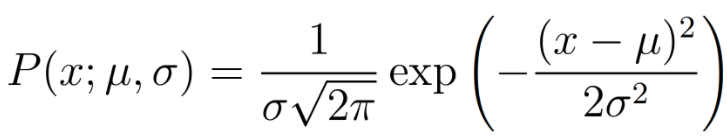

Оценка максимальной вероятности *(англ. maximum likelihood estimate)* - считает вероятность, что при сэмплирования  рандомного примера с нормального распределения (которое задается через среднее значение μ и ст. отклонение σ), мы получим результат равен Х.  

Используя оценку максимальной вероятности, мы можем посчитать *расстояние* между действиями, которые предсказывает актёр, и действиями которые мы получаем после добавление шума. 

Но функция ошибки выше требует чтобы мы использовали не саму оценку максимальной вероятности, а её *логарифм*. Преобразовывая выше-указанное уравнение в лог-пространство, мы получаем следующее:


In [ ]:
#Функция которая считает логариым оценки максимального правдоподобия между двумя распределениями с numpy-массивами
def log_maximum_likelihood(actions, predictions): 
  #Применяем уравнение -> P(x;μ,σ) = -((X - Y)^2 / (2*σ^2)) + 2*ln(σ) + ln(2*π)
  squared_difference = (actions - predictions)**2 #Записываем (X - Y)^2 в одну переменную
  squared_std = np.exp(log_standard_deviation)**2 #Записываем σ^2 в одну переменную (log_standard_deviation - это ln(σ), по этому мы возводим переменную в экспонент)

  predict_sum = squared_difference/(-2.0 * squared_std) - log_standard_deviation - np.log((2.0*np.pi)**0.5) #Считаем логарифм оценки максимального правдоподобия
  return np.sum(predict_sum, axis=1) #Возвращаем сумму всех оценок за каждое действие

Выше указанная функция будет использоваться для оценки максимального правдоподобия между предсказанными действиями (μ,σ) и действиями после добавления шума (Х). 

Оценка максимальной вероятности используется внутри функции `choose_action`, а также в функции ошибки актёра. В первой, мы получаем лог-максимальные правдоподобия с старой политики (`old_log_maximum_likelihoods`), а во второй, мы получаем лог-максимальные правдоподобия с новой политики (`current_log_maximum_likelihoods`). Соотношение между двумя значениями затем используется также, как в варианте с дискретными действиями.

Сама ошибка пытается максимизировать результат умножения преймуществ и минимумом между урезанных и первоначальных соотношений максимальных вероятностей. Именно благодаря использованию урезанных соотношений, функция ошибки дает актёру стимул не уходить далеко от текущей политики (т.е. оценки макс. вероятностей после обучения не уходят далеко от оценок макс. вероятностей до обучения). Таким образом, создается основной принцип работы алгоритма БОП - происходит много *маленьких* шагов обучения внутри доверительного региона.  

#Обобщенные оценки преймуществ

Последняя тема, которую мы рассмотрим в текущем занятии, это обобщенные оценки преймуществ *(англ. generalized advantage estimates)*. 

Обобщенные оценки преймуществ предоставляют альтернативную логику для подсчета преймуществ. Этот альтернативный подход можно использовать в решении практический любой задачи, и во многих случаях, он приводит к более качественному и стабильному обучению.

Функция для вычисления обобщенных преймуществ выглядит следующим образом:

In [ ]:
#Функция подсчета обобщенных оценок преймущества 
#принимает на вход массив наград, значений текущих состояний, значений следующих состояний, и индикаторов статуса завершения эпизода
def get_GAE(rewards, current_values, next_values, dones):
  #Сначала мы используем лист-компрешеншен чтобы "предобработать" награды
  deltas = np.array([reward + (1 - done) * gamma * next_value - current_value for \
                     reward, next_value, current_value, done in zip(rewards, next_values, current_values, dones)]) #и также переводим результат в numpy-массив.

  generalized_advantage_estimates = np.zeros_like(deltas) #Создаем массив из нулей с одинаковой размерностью, куда будем записывать обобщенные значения преймуществ
  
  for i in reversed(range(len(rewards) - 1)): #Проходимся по индексам массива в цикле, в обратном порядке
    generalized_advantage_estimates[i] = deltas[i] + (1 - dones[i]) * gamma * lamda * deltas[i + 1] #Считаем обобщенные значения преймуществ
    
  return generalized_advantage_estimates #Возвращаем подсчитанные значения

Выше-представленный код использует новый гиперпараметр λ (`lamda`). В литературе, этот гиперпараметр часто называют **параметр сглаживания**.

На вход функции подаются награды (`rewards`), значения, которые критик предсказывает по состояниям s (`current_values`), значения, которые критик предсказывает по состояниям s' (`next_values`), и статусы завершения эпизода (`dones`). Нужно отметить, что благодаря использованию `dones` в коде выше, функция способна обрабатывать данные не только для одного эпизода, но и за несколько эпизодов одновременно.  



###Обобщенные оценки наград - наглядно в коде

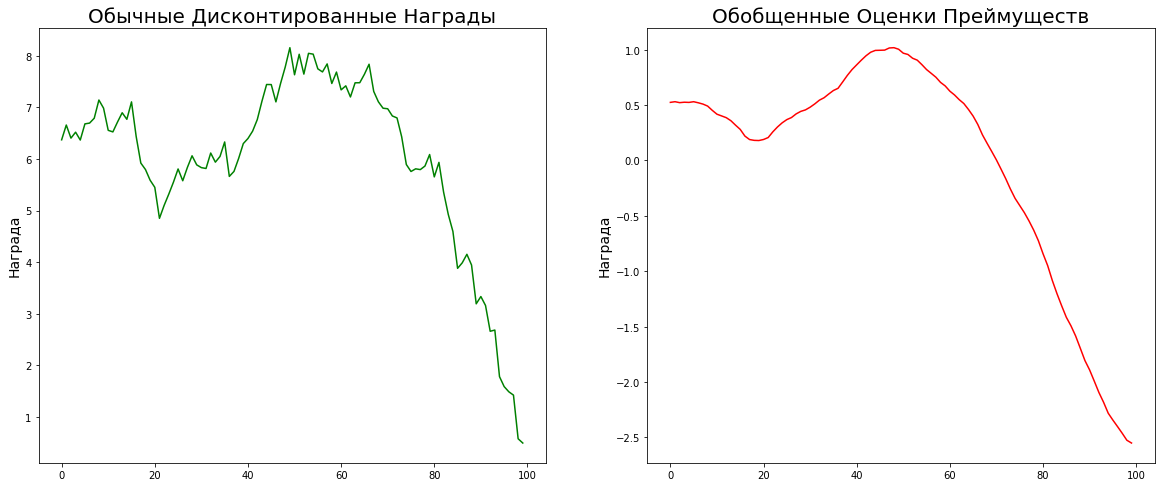

In [ ]:
import numpy as np               #Импортируем библиотеку numpy
import matplotlib.pyplot as plt  #Имтортируем модуль pyplot 

rewards_array = np.random.random((100))**2   #Создаем условный массив наград
gamma = 0.95  #Задаем гиперпараметр γ
lamda = 0.90  #Задаем гиперпараметр λ

#Задаем функцию для дисконтирование наград (функция такая же как в предыдущих занятиях)
def preprocess_rewards(rewards, gamma): 
  processed_rewards = np.zeros_like(rewards).astype(np.float32) #Инициализируем новый массив нулями, куда будем записывать предобрадотанные награды
  running_add = 0 #Инициализируем значение скользящей суммы нулём
  for i in reversed(range(0, len(rewards))): #Проходимся черех массив наград в обратном порядке
    running_add = running_add * gamma + rewards[i] # sum * y (gamma) + reward (псевдо-уравнения бэллмена)
    processed_rewards[i] = running_add         #Устанавливаем значение награды в соответствии уравнения бэллмена
  return processed_rewards.flatten()           #Возвращаем одномерный список наград

vanilla_rewards = preprocess_rewards(rewards_array, gamma = gamma) #Получаем массив дисконтированных наград

lamda_rewards = preprocess_rewards(vanilla_rewards, gamma = lamda) #Дисконтируем награды ещё раз и получаем дважды дисконтированные награды
GAEs = (lamda_rewards - lamda_rewards.mean())/lamda_rewards.std() #Приводим результат в нормальное распределение и этим получаем обобщенные оценки преймуществ

#Создаем графики
fig, ax = plt.subplots(1, 2, figsize = (20, 8))  #Создаем два полотна для визуализации результата

ax[0].plot(vanilla_rewards, color = 'green')  #Отрисовываем обычные обработанные награды
ax[0].set_ylabel("Награда", fontsize = 14) #Задаем лейбл по оси У
ax[0].set_title("Обычные Дисконтированные Награды", fontsize = 20) #Задаем заголовог

ax[1].plot(GAEs, color = 'red')  #Отрисовываем обобщенные оценки преймуществ
ax[1].set_ylabel("Награда", fontsize = 14) #Задаем лейбл по оси У
ax[1].set_title("Обобщенные Оценки Преймуществ", fontsize = 20) #Задаем заголовог

plt.show() #Отображаем результат

**Изображение №3**

<font color='gray'>Графики выше показывают те же награды, дисконтированны с значением λ = 0 (слева), и с значением λ = 0.9 (справа).</font>

<font color='gray'>То есть, график слева покаывает нам массив наград, который обработан привычной нам функцией с предыдущих занятий, тем временем как график справа показывает график наград которые, но факту, обрабатываются дважды - и тем "сглаживаются".</font>

<font color='gray'>Чтобы получить обобщенные оценки преймуществ, мы затем нормируем эти "дважды дисконтированные" награды.</font>

Если посмотреть внимательно, мы можем увидеть что функция `get_GAE()` очень сильно похожа на функцию предобработки наград с предыдущих занятий. Фактический, эта функция разбрасывает награды дважды - первый раз с гиперпараметром γ, а второй раз с гимерпараметром λ. Именно это и происходит в коде выше, засчет чего награды становяться более "обобщенными", ползовяют агенту обучаться стабильнее при наличии зашумленных наград.  

На этом заканчивается теоретическая часть этого занятия. Далее мы посмотрим как все темы, которые мы только что изучили, можно применить в коде.  

##Внешние ресурсы:

[Habr - теоретическое/математическое объяснения алгоритма БОП](https://habr.com/ru/post/555202/)

[Официальный сайт среды TORCS](http://torcs.sourceforge.net/)

[Статья про оценку максимального правдоподобия](https://datascience.eu/ru/программирование/оценка-максимального-правдоподобия/)